### Data from the paper: [Discovery of a structural class of antibiotics with explainable deep learning](https://www.nature.com/articles/s41586-023-06887-8)

In [1]:
# Standard
import logging
import importlib

# Third party
import numpy as np
import pandas as pd
import rdkit
from rdkit import RDLogger
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
import torchmetrics
from torchmetrics import AUROC

# GT-PyG
import gt_pyg
from gt_pyg.data.utils import (
    get_tensor_data,
    get_node_dim,
    get_edge_dim,
    clean_df,
)
from gt_pyg.nn.model import GraphTransformerNet


# Turn off majority of RDKit warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


# Set a random seed for a reproducibility purposes
torch.manual_seed(1928374650)

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Log the used versions of RDkit and torch
print(f'Numpy version: {np.__version__}')
print(f'Rdkit version: {rdkit.__version__}')
print(f'Torch version: {torch.__version__}')
print(f'TorchMetrics version: {torchmetrics.__version__}')

/Users/pawel/anaconda3/envs/gt/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Numpy version: 1.21.6
Rdkit version: 2022.09.5
Torch version: 1.13.1
TorchMetrics version: 0.11.4


## The training dataset

**Note**: 39,312 compounds for the antibacterial activity againts _S. aureus_ (Gram-positive pathogen)

The training set was downloaded from the [original repo](https://github.com/felixjwong/antibioticsai) on 12/31/2023.

Reference: _Wong et al., Nature, 2023_

In [2]:
dataset_filename = './data/train.antibioticsai.csv'
df = pd.read_csv(dataset_filename, sep=',')
df = df.rename(columns={'SMILES': 'smiles', 'ACTIVITY': 'activity'})
df.head()

,smiles,activity
0,Nc1nnc(o1)-c1ccc(o1)[N+](=O)[O-],1
1,O[C@H]1COC[C@@H]2O[C@H](CC[C@H]2N(C1)C(=O)Nc1c...,1
2,CC(C)C[C@@H](N)C(=O)N[C@@H]1[C@H](O)c2ccc(c(c2...,1
3,[O-][N+](=O)c1ccc(o1)/C=N/N1CC(=O)NC1=O,1
4,Cn1cnc(c1)CCNC(=O)C[C@@H]1CC[C@@H]2[C@H](COC[C...,1


The paper seems to be employing either a random or stratified split for evaluating the model. In the exercise below, we opt for the random split, as when N approaches infinity, the statistics for both random and stratified splits converge. We generate training, validation, and test sets, maintaining the same proportions as outlined in the original paper.

In [3]:
def get_random_split(df, frac=[0.8, 0.1, 0.1], min_num_atoms=0):
    
    # Assert that the sum of fractions is equal to 1
    assert sum(frac) == 1, "The sum of fractions must be equal to 1"

    # Shuffle the DataFrame rows to get a random split
    shuffled_df = df.sample(frac=1, random_state=42)

    # Calculate the number of rows for each set
    total_rows = len(shuffled_df)
    train_rows = int(frac[0] * total_rows)
    val_rows = int(frac[1] * total_rows)

    # Split the DataFrame
    train_set = shuffled_df.iloc[:train_rows]
    val_set = shuffled_df.iloc[train_rows:train_rows + val_rows]
    test_set = shuffled_df.iloc[train_rows + val_rows:]

    train_set = clean_df(train_set, min_num_atoms=min_num_atoms, x_label='smiles', y_label='activity')
    val_set = clean_df(val_set, min_num_atoms=min_num_atoms, x_label='smiles', y_label='activity')
    test_set = clean_df(test_set, min_num_atoms=min_num_atoms, x_label='smiles', y_label='activity')
    
    return (train_set, val_set, test_set)

We set the minimum number of atoms in a molecule to 4, as we utilize 6 eigenvectors for spectral positional encoding. It is important to note that this exclusion affects compounds in both the training and validation sets, but not in the test set.

In [4]:
PE_DIM = 6
(tr, va, te) = get_random_split(df, frac=[0.8, 0.1, 0.1], min_num_atoms=4)
tr_dataset = get_tensor_data(tr.smiles.to_list(), tr.activity.to_list(), pe_dim=PE_DIM)
va_dataset = get_tensor_data(va.smiles.to_list(), va.activity.to_list(), pe_dim=PE_DIM)
te_dataset = get_tensor_data(te.smiles.to_list(), te.activity.to_list(), pe_dim=PE_DIM)
NODE_DIM = get_node_dim()
EDGE_DIM = get_edge_dim()

print(f'Number of training examples: {len(tr_dataset)}')
print(f'Number of validation examples: {len(va_dataset)}')
print(f'Number of test examples: {len(te_dataset)}')

train_loader = DataLoader(tr_dataset, batch_size=256)
val_loader = DataLoader(va_dataset, batch_size=1024)
test_loader = DataLoader(te_dataset, batch_size=1024)

INFO:root:Removed 7 compounds that did not meet the size criteria.
INFO:root:Removed 1 compounds that did not meet the size criteria.
INFO:root:Removed 0 compounds that did not meet the size criteria.


Number of training examples: 31442
Number of validation examples: 3930
Number of test examples: 3932


In [5]:
original_number_of_cmpds = len(df)
num_tr = len(tr)
num_ve = len(va)
num_te = len(te)
print(f'Removed {original_number_of_cmpds - num_tr - num_ve - num_te} compounds.')

Removed 8 compounds.


## Train and eval the GT model

### Auxiliary functions

Due to the significant imbalance in the training set, we apply an upweighting technique to the positive class during the calculation of the loss value.

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

from torch.nn.functional import one_hot

def calculate_class_ratio(labels):
    pos_class = sum(labels)
    neg_class = len(labels) - pos_class
    
    ratio = max(1, neg_class) / max(1, pos_class)
    return torch.tensor(ratio)


def train(epoch):
    model.train()
    auroc = AUROC(task="binary")

    for data in train_loader:
        pos_weight = calculate_class_ratio(data.y)
        loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        data = data.to(device)
        optimizer.zero_grad()
        
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
        (out, _) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch, zero_var=True)
        loss = loss_func(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()
        
        auroc.update(out.squeeze(), data.y)

    return auroc.compute()


@torch.no_grad()
def test(loader):
    model.eval()
    auroc = AUROC(task="binary")
    
    for data in loader:
        data = data.to(device)
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
        (out,_) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
        
        auroc.update(out.squeeze(), data.y)
        
    return auroc.compute()

@torch.no_grad()
def calc_auprc(loader):
    (scores, labels) = score(loader)
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    return (auc(recall, precision), scores, labels)

@torch.no_grad()
def score(loader):
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
            logits, _ = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
            all_logits.append(logits.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_logits = np.concatenate(all_logits)
    all_labels = np.concatenate(all_labels)

    return (all_logits, all_labels)

## GraphTransformer architecture

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphTransformerNet(node_dim_in=NODE_DIM,
                            edge_dim_in=EDGE_DIM,
                            pe_in_dim=PE_DIM,
                            num_gt_layers=4, 
                            hidden_dim=128,
                            num_heads=8,
                            norm='bn',
                            gt_aggregators=['sum', "mean"],
                            aggregators=['sum','mean','max', 'std'],
                            dropout=0.2,
                            act='gelu',
                            gate=True).to(device)

if int(torch.__version__.split('.')[0]) >= 2:
    model = torch_geometric.compile(model) 

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,
                              min_lr=0.00001)

print(model)
print(f"Number of params: {model.num_parameters()//1000} k")


best_epoch = 0
best_validation_loss = -np.inf
test_set_auroc = -np.inf

best_labels, best_scores = None, None
for epoch in range(1, 51):
    tr_auroc = train(epoch)
    #va_auroc = test(val_loader)
    #te_auroc = test(test_loader)
    
    (tr_auprc, _, _) = calc_auprc(train_loader)
    (va_auprc, _, _) = calc_auprc(val_loader)
    (te_auprc, scores, labels) = calc_auprc(test_loader)
    scheduler.step(va_auprc)
    #print(f'Epoch: {epoch:02d}, AUROC: Train: {tr_auroc:.4f}, Val: {va_auroc:.4f}, '
    #      f'Test: {te_auroc:.4f}')
    print(f'Epoch: {epoch:02d}, AUPRC= Train: {tr_auprc:.4f} (AUROC= {tr_auroc:.4f}), Val: {va_auprc:.4f}, '
          f'Test: {te_auprc:.4f}')
        
    va_loss = va_auprc
    te_loss = te_auprc
    
    if va_loss > best_validation_loss:
        best_epoch = epoch
        best_validation_loss = va_loss
        test_set_auroc = te_loss
        
        best_labels = labels
        best_scores = scores
        
print("\nModel's performance on the test set\n"
        "===================================\n"
        f'AUROC={test_set_auroc}\n'
        f'Epoch={best_epoch}')

GraphTransformerNet(
  (node_emb): Linear(in_features=76, out_features=128, bias=False)
  (edge_emb): Linear(in_features=10, out_features=128, bias=False)
  (pe_emb): Linear(in_features=6, out_features=128, bias=False)
  (gt_layers): ModuleList(
    (0): GTConv(128, 128, heads=8, aggrs: sum,mean, qkv_bias: False, gate: True)
    (1): GTConv(128, 128, heads=8, aggrs: sum,mean, qkv_bias: False, gate: True)
    (2): GTConv(128, 128, heads=8, aggrs: sum,mean, qkv_bias: False, gate: True)
    (3): GTConv(128, 128, heads=8, aggrs: sum,mean, qkv_bias: False, gate: True)
  )
  (global_pool): MultiAggregation([
    SumAggregation(),
    MeanAggregation(),
    MaxAggregation(),
    StdAggregation(),
  ], mode=cat)
  (mu_mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (log_var_mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features

## Area under Precision-Recall curve (AUPRC)

In the original paper, the AUPRC is approximately ~0.35-0.37; however, an exact comparison is not feasible due to the lack of specific information regarding the training, validation, and test sets. Despite this, in our first attempt, we already achieved performance comparable to the optimized ensemble model used in the paper.

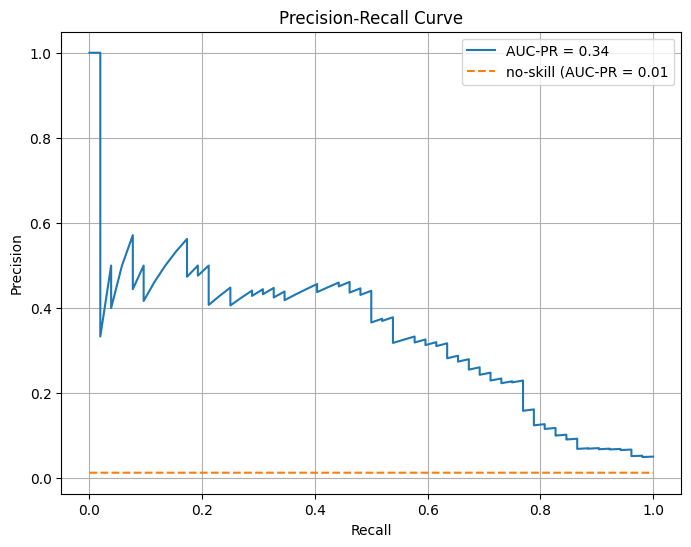

In [ ]:
# Calculate precision and recall values at different probability thresholds
precision, recall, thresholds = precision_recall_curve(best_labels, best_scores)

# Calculate the area under the precision-recall curve
auc_pr = auc(recall, precision)

# Add precision-recall curve for a random model
random_predictions = np.random.rand(len(best_labels))
random_precision, random_recall, _ = precision_recall_curve(best_labels, random_predictions)
random_auc_pr = auc(random_recall, random_precision)

positive_ratio = np.sum(best_labels) / len(best_labels)
random_skill_recall = np.linspace(0, 1, len(best_labels))
random_skill_precision = np.full_like(random_skill_recall, positive_ratio)
random_skill_auc_pr = auc(random_skill_recall, random_skill_precision)


# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.plot(random_skill_recall, random_skill_precision, linestyle='--', label=f'no-skill (AUC-PR = {random_skill_auc_pr:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()